AR signature in python
converted from Artem Sokolov and Vlado Uzunangelov's R code

In [46]:
import pandas as pd
import numpy as np
from sklearn import linear_model, kernel_ridge
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from matplotlib import pyplot as plt
from bokeh.charts import Bar, output_file, show
from bokeh.io import output_notebook
from bokeh.sampledata.autompg import autompg as df
from bokeh.charts.attributes import ColorAttr, CatAttr


pd.options.mode.chained_assignment = None # supress pandas copy-by-ref warning
%matplotlib inline
output_notebook()

Loading BokehJS ...

In [6]:
X_file = "data/AR_sig_celline.tab"
Y_file = "data/ar_cell_line_clin.txt"
X_WCDT_file = "data/filtered_mrna.tab"

X_df = pd.read_csv(X_file, delimiter="\t")
Y_df = pd.read_csv(Y_file, delimiter="\t")
WCDT_df = pd.read_csv(X_WCDT_file, delimiter="\t")
# print(Y_df)

In [7]:
def data_prep(X_df, Y_df):
    # take "ligand" column as Y label and set "on" to 1 and "no ligand" to 0
    Y_df = Y_df[["GSM_ID", "ligand"]]
    Y_df['ligand'] = Y_df['ligand'].replace(['on'], 1)
    Y_df['ligand'] = Y_df['ligand'].replace(['no ligand'], 0)
    
    # Drop sample GSM288299, GSM288300, GSM288301 (QA by Robert and Jack)
    Y_df = Y_df[~Y_df.GSM_ID.isin(["GSM288299", "GSM288300", "GSM288301"])]
    
    # remove non-overlapping samples in X and Y
    common_samples = sorted(list(set(Y_df.GSM_ID).intersection(set(X_df.columns[1:]))))
    X_df = X_df[["Gene Symbol"] + common_samples]
    Y_df = Y_df[Y_df.GSM_ID.isin(common_samples)]
    
    # remove genes with NA
    X_df = X_df.dropna()
    
    # get overlap of genes between X_df and WCDT file
    WCDT_df = pd.read_csv(X_WCDT_file, delimiter="\t")
    common_genes = set(WCDT_df["gene_id"]).intersection(set(X_df["Gene Symbol"]))
    X_df = X_df[X_df["Gene Symbol"].isin(common_genes)]
    
    # rank transformation + normalization (with quantile function of exponential distribution) 
    X_df.set_index("Gene Symbol", inplace=True)
    X_orig_df = X_df.copy()
    X_df = (X_df.rank()-1)/len(X_df)
    X_df = X_df.applymap(lambda x: -np.log(1-x))

    # transpose X
    X_df = X_df.transpose()
    X_orig_df = X_orig_df.transpose()
    
    # set GSM_id as Y index
    Y_df.set_index("GSM_ID", inplace=True)    
    
    # order X and Y so that same sample name match up
    X_df.sort_index(inplace=True)
    Y_df.sort_index(inplace=True)
    assert(list(X_df.index) == list(Y_df.index))
    
    # prep WCDT data
    WCDT_df = pd.read_csv(X_WCDT_file, delimiter="\t")
    common_genes = set(WCDT_df["gene_id"]).intersection(set(X_df.columns))
    WCDT_df = WCDT_df[WCDT_df["gene_id"].isin(common_genes)]
    WCDT_df.set_index("gene_id", inplace=True)
    
    # same normalization
    WCDT_df = (WCDT_df.rank()-1)/len(WCDT_df)
    WCDT_df = WCDT_df.applymap(lambda x: -np.log(1-x))
    WCDT_df.sort_index(inplace=True)
    WCDT_df = WCDT_df.transpose()

    return X_orig_df, X_df, Y_df, WCDT_df

In [8]:
_, X, Y, WCDT_df = data_prep(X_df, Y_df)

In [9]:
def get_artem_sig(plot=False):
    df1 = pd.read_csv("data/ar-sig.rnk", delimiter="\t", 
                      names=["gene","gelnet_ker"], index_col=0)
    df2 = pd.read_csv("data/ar-sig-gelnet.rnk", delimiter="\t", 
                      names=["gene","gelnet"], index_col=0)
    # scale both data set to [0, 1] by minmax scaling
    df = pd.concat([df1, df2], axis=1)     
    if plot:
        plt.figure(1)
        plt.scatter(df['gelnet_ker'], df['gelnet'])
        plt.xlabel("R gelnet.ker")
        plt.ylabel("R gelnet")
        plt.title("pearson corr %.2f" %stats.pearsonr(df['gelnet_ker'], df['gelnet'])[0])
    return df

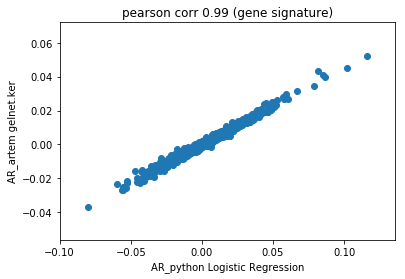

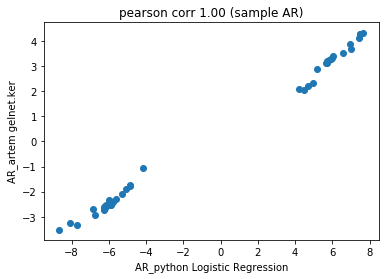

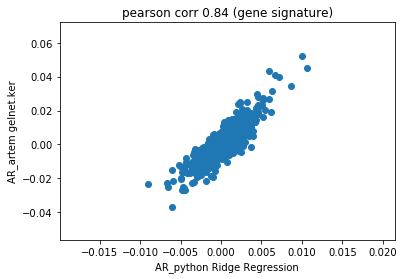

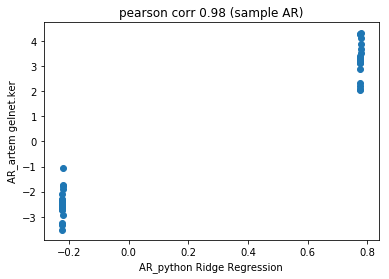

In [10]:
classifiers = {#"Enet": linear_model.ElasticNet(alpha=0.1, l1_ratio=0.001),
               "Logistic Regression": linear_model.LogisticRegression(), 
               #"Lasso": linear_model.Lasso(alpha=0.01), 
               "Ridge Regression": linear_model.Ridge(),
               #"KernelRidge": kernel_ridge.KernelRidge()
              }

sig_df = get_artem_sig()
assert(list(X.columns) == list(sig_df.index))
assert(list(X.index) == list(Y.index))

for classifier_name, classifier in classifiers.items():
    classifier.fit(X, Y['ligand'])
    if len(classifier.coef_) == 1:
        coef = classifier.coef_[0]
    else:
        coef = classifier.coef_
    sig_df[classifier_name] = coef
    sig_df.to_pickle("AR_signatures.pkl")
    
    plt.figure(classifier_name)
    plt.scatter(sig_df[classifier_name], sig_df['gelnet_ker'])
    plt.title("pearson corr %.2f (gene signature)" %stats.pearsonr(sig_df[classifier_name], sig_df['gelnet_ker'])[0])
    plt.xlabel("AR_python %s" %classifier_name)
    plt.ylabel("AR_artem gelnet.ker")

    AR_artem = np.matmul(X.as_matrix(), sig_df['gelnet_ker'].as_matrix())
    AR_python = np.matmul(X.as_matrix(), sig_df[classifier_name].as_matrix())
    plt.figure(classifier_name + "AR")
    plt.scatter(AR_python, AR_artem)
    plt.title("pearson corr %.2f (sample AR)" %stats.pearsonr(AR_python, AR_artem)[0])
    plt.xlabel("AR_python %s" %classifier_name)
    plt.ylabel("AR_artem gelnet.ker")

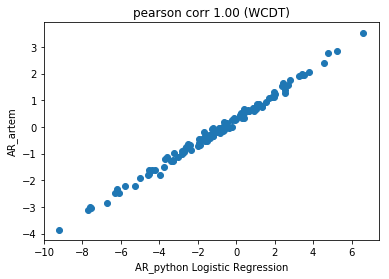

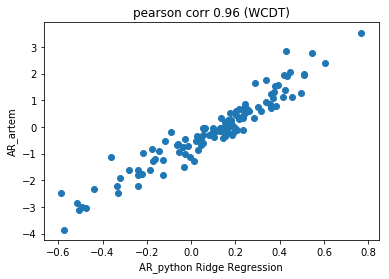

In [11]:

assert(list(WCDT_df.columns) == list(sig_df.index))

for classifier_name, classifier in classifiers.items():
    plt.figure("WCDT"+classifier_name)
    AR_artem = np.matmul(WCDT_df.as_matrix(), sig_df['gelnet_ker'].as_matrix())
    AR_python = np.matmul(WCDT_df.as_matrix(), sig_df[classifier_name].as_matrix())
    plt.scatter(AR_python, AR_artem)
    plt.title("pearson corr %.2f (WCDT)" %stats.pearsonr(AR_python, AR_artem)[0])
    plt.xlabel("AR_python %s" %classifier_name)
    plt.ylabel("AR_artem")

In [12]:
def leave_pair_out_test(X, Y, sig):
    assert(list(X.columns)==list(sig.index))
    pairs = get_all_01_pairs(Y)
    print(len(pairs))
    auc = calc_auc(X, pairs, sig)
    return auc


def get_all_01_pairs(Y):
    pairs = []
    zeros = Y[Y.ligand==0].index
    ones = Y[Y.ligand==1].index    
    for zero in zeros:
        for one in ones:
            pairs.append((zero, one))
    return pairs


def calc_auc(X, pairs, sig):
    """
    leave pair out auc defined in this paper:
    http://www.jmlr.org/proceedings/papers/v8/airola10a/airola10a.pdf
    """ 
    sigs = np.matmul(X, sig)
    sig_dict = dict(zip(X.index, sigs))
    auc = []
    for pair in pairs:
        zero = sig_dict[pair[0]]
        one = sig_dict[pair[1]]
        if zero < one:
            auc.append(1)
        elif zero == one:
            auc.append(0.5)
    auc = float(sum(auc))/len(pairs)
    return auc

for sig_type in sig_df.columns:
    auc = leave_pair_out_test(X, Y, sig_df[sig_type])
    print(sig_type)
    print("auc: %.4f" %auc)
    

418
gelnet_ker
auc: 1.0000
418
gelnet
auc: 1.0000
418
Logistic Regression
auc: 1.0000
418
Ridge Regression
auc: 1.0000


In [13]:
classifiers = {#"Enet": linear_model.ElasticNet(alpha=0.1, l1_ratio=0.001),
               "Logistic Regression": linear_model.LogisticRegression(), 
               #"Lasso": linear_model.Lasso(alpha=0.01), 
               #"Ridge Regression": linear_model.Ridge(),
               #"KernelRidge": kernel_ridge.KernelRidge()
              }

def LPOCV(X, Y):
    """
    leave pair out cross validation
    """
    pairs = get_all_01_pairs(Y)
    auc = []
    for pair in pairs:
        X_train = X[~X.index.isin(pair)]
        Y_train = Y[~Y.index.isin(pair)]
        X_test = X[X.index.isin(pair)]
        Y_test = Y[Y.index.isin(pair)]
        assert(list(X_train.index)==list(Y_train.index))
        assert(list(X_test.index)==list(Y_test.index))        
        classifiers["Logistic Regression"].fit(X_train, Y_train['ligand'])
        coef = classifiers["Logistic Regression"].coef_[0]
        Y_pred = np.matmul(X_test, coef)        
        auc.append(calc_auc_cv(Y_pred, Y_test))
    auc = float(sum(auc))/len(pairs)
    return auc
    
        
def calc_auc_cv(Y_pred, Y_test):
    Y_test = list(Y_test['ligand'])
    assert(Y_test[1] != Y_test[0])
    if Y_test[1] > Y_test[0]:
        zero = Y_pred[0]
        one = Y_pred[1]
    else:
        zero = Y_pred[1]
        one = Y_pred[0]
    if zero == one:
        return 0.5
    elif zero < one:
        return 1
    else:
        return 0

In [14]:
print(LPOCV(X, Y))

1.0


In [15]:
_, X, Y, WCDT_df = data_prep(X_df, Y_df)
sig_df = pd.read_pickle("AR_signatures.pkl")

              Pre      Post  Post-Pre
Sample                               
DTB-080 -0.121793  -7.71966  -7.59787
DTB-063   0.42224  -4.52588  -4.94812
DTB-176  0.398765  -3.73529  -4.13405
DTB-194  -0.23242  -3.68481  -3.45239
DTB-141  0.176131  -2.79904  -2.97517
DTB-149     1.693 -0.813943  -2.50694
DTB-127  0.896423  -1.42692  -2.32334
DTB-137   0.60286  -1.53947  -2.14233
DTB-135  0.305732  -1.63618  -1.94191
DTB-060   4.56127   3.42715  -1.13412
DTB-024 -0.580551  -1.27299  -0.69244
DTB-022 -0.974636 -0.644036  0.330599
DTB-102  0.247675  0.635457  0.387783
DTB-073  -1.26859   1.34314   2.61173
DTB-111  -2.50477   1.99217   4.49694
DTB-089  -3.30639   1.19885   4.50524


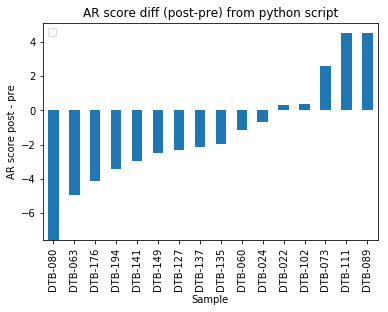

In [77]:
def extract_sample_name(name):
    if name.endswith("Pro"):
        return name[:-3]
    elif name.endswith("Pro2"):
        return name[:-4]
    else:
        assert(name[-1] in "0123456789")
        return name


assert(list(sig_df.index) == list(WCDT_df.columns))
WCDT_AR_scores = np.matmul(WCDT_df, sig_df["Logistic Regression"])
WCDT_score_df = pd.DataFrame(WCDT_AR_scores, index=WCDT_df.index, columns=["score"])
sample_pair = pd.read_csv("data/paired_samples", delimiter="\t", index_col="Sample")
WCDT_score_df = WCDT_score_df[WCDT_score_df.index.isin(sample_pair.index)]
assert(sorted(list(sample_pair.index))==sorted(list(WCDT_score_df.index)))
sample_pair_dict = dict(zip(sample_pair.index, sample_pair['TimePoint']))
WCDT_plot_df = pd.DataFrame(columns=["Pre", "Post"])
for index, row in WCDT_score_df.iterrows():
    sample_name = extract_sample_name(index)
    sample_type = sample_pair_dict[index]
    WCDT_plot_df.set_value(sample_name, sample_type, row.score)

WCDT_plot_df["Post-Pre"] = WCDT_plot_df["Post"] - WCDT_plot_df["Pre"]
WCDT_plot_df.sort_values(by="Post-Pre", inplace=True)
WCDT_plot_df.index.rename("Sample", inplace=True)
print(WCDT_plot_df)


ax = WCDT_plot_df.plot.bar(y="Post-Pre")
ax.set_ylabel("AR score post - pre")
ax.set_title("AR score diff (post-pre) from python script")
ax.legend("")